# Subclustering within parent clusters + prognostic validation (no leakage)

This notebook starts from a prepared dataframe `df` that already contains a **parent cluster** column `cluster ∈ {1,2}`.

Goal:
- Find **subclusters** inside each parent cluster (1 and 2) using **only clinical features** (no outcome leakage).
- Run two feature views to avoid self-deception:
  - **View A (clinical phenotype):** numeric + categorical (excludes missingness/flags)
  - **View B (operational/data availability):** numeric + categorical + flags/missing indicators
- Profile subclusters clinically.
- Validate whether subclusters separate prognosis **within each parent cluster** (Kaplan–Meier + log-rank).

Critical anti-leakage rule:
- `event` and `time_days` are **never** used as features for subclustering.
- Outcomes are used **only** in the survival validation section.

Outputs (written to `cluster/`):
- `cluster/df_con_subclusters.csv`
- `cluster/perfil_subclusters.csv`


In [10]:
# Imports & global settings
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from scipy import stats

from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(RANDOM_STATE)

TARGET_EVENT = "event"
TARGET_TIME = "time_days"
PARENT_CLUSTER = "cluster"

OUTPUT_DIR = Path("cluster")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 110,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

def _clean_cat_value(x):
    """Normalize category-like values (e.g., '2.0' -> '2') without creating NaNs."""
    if pd.isna(x):
        return x
    s = str(x)
    if s.endswith(".0"):
        head = s[:-2]
        if head.replace("-", "").isdigit():
            return head
    return s

def clean_as_category(s: pd.Series) -> pd.Series:
    return s.map(_clean_cat_value).astype("category")


In [11]:
# 0) Load df (must already include parent cluster column)

CANDIDATE_INPUTS = [
    Path("cluster/df_con_clusters.csv"),
    Path("df_con_clusters.csv"),
    Path("Dades/dt_model.csv"),
]

INPUT_PATH = next((p for p in CANDIDATE_INPUTS if p.exists()), None)
if INPUT_PATH is None:
    raise FileNotFoundError(
        "Could not find an input CSV. Expected one of: " + ", ".join(map(str, CANDIDATE_INPUTS))
    )

df = pd.read_csv(INPUT_PATH)
if "Unnamed: 0" in df.columns and df["Unnamed: 0"].is_unique:
    df = df.set_index("Unnamed: 0")

# Column lists (as specified)
num_cols = [
    "imc",
    "valor_de_ca125",
    "tamano_tumoral",
    "recep_est_porcent",
    "rece_de_Ppor",
    "edad_en_cirugia",
]

cat_cols = [
    "asa",
    "histo_defin",
    "grado_histologi",
    "FIGO2023",
    "afectacion_linf",
    "metasta_distan",
    "AP_centinela_pelvico",
    "AP_ganPelv",
    "AP_glanPaor",
    "beta_cateninap",
]

flag_cols = [
    "histo_defin__from_pre",
    "grado_histologi__from_pre",
    "FIGO2023__from_pre",
    "imc_miss",
    "tamano_tumoral_miss",
    "valor_de_ca125_miss"
]

required_cols = set(num_cols + cat_cols + flag_cols + [TARGET_EVENT, TARGET_TIME, PARENT_CLUSTER])
missing = sorted(required_cols - set(df.columns))
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Enforce dtypes
for col in num_cols:
    df[col] = df[col].astype("float64")
for col in cat_cols:
    df[col] = clean_as_category(df[col])
for col in flag_cols:
    df[col] = df[col].astype("int8")

df[TARGET_EVENT] = df[TARGET_EVENT].astype("int64")
df[TARGET_TIME] = df[TARGET_TIME].astype("int64")
df[PARENT_CLUSTER] = df[PARENT_CLUSTER].astype("int64")

feature_cols = [c for c in df.columns if c not in [TARGET_EVENT, TARGET_TIME, PARENT_CLUSTER]]
expected_feature_set = set(num_cols + cat_cols + flag_cols)
if set(feature_cols) != expected_feature_set:
    missing_f = sorted(expected_feature_set - set(feature_cols))
    extra_f = sorted(set(feature_cols) - expected_feature_set)
    raise ValueError(
        "feature_cols mismatch vs expected schema. "
        f"Missing: {missing_f}; Extra: {extra_f}"
    )

# Hard checks
if df.isna().any().any():
    na_cols = df.columns[df.isna().any()].tolist()
    raise ValueError(f"NaNs detected in columns: {na_cols}")

event_values = set(df[TARGET_EVENT].unique().tolist())
if not event_values.issubset({0, 1}):
    raise ValueError(f"{TARGET_EVENT} must be binary {{0,1}}; got {sorted(event_values)}")

if (df[TARGET_TIME] < 0).any():
    raise ValueError(f"{TARGET_TIME} contains negative values")

clusters = set(df[PARENT_CLUSTER].unique().tolist())
if clusters != {1, 2}:
    raise ValueError(f"{PARENT_CLUSTER} must have exactly values {{1,2}}; got {sorted(clusters)}")

print("Input path:", INPUT_PATH)
print("df.shape:", df.shape)
print("\n(df.dtypes)\n", df.dtypes)
print("\n(df.head)\n", df.head())


Input path: cluster/df_con_clusters.csv
df.shape: (147, 25)

(df.dtypes)
 imc                           float64
asa                          category
valor_de_ca125                float64
histo_defin                  category
grado_histologi              category
FIGO2023                     category
tamano_tumoral                float64
afectacion_linf              category
metasta_distan               category
AP_centinela_pelvico         category
AP_ganPelv                   category
AP_glanPaor                  category
recep_est_porcent             float64
rece_de_Ppor                  float64
beta_cateninap               category
event                           int64
time_days                       int64
edad_en_cirugia               float64
histo_defin__from_pre            int8
grado_histologi__from_pre        int8
FIGO2023__from_pre               int8
imc_miss                         int8
tamano_tumoral_miss              int8
valor_de_ca125_miss              int8
cluster       

In [12]:
# 1) Mandatory audit

sizes_parent = df[PARENT_CLUSTER].value_counts().sort_index()
print("Parent cluster sizes:")
print(sizes_parent)

print("\nEvent-rate and time_days summary by parent cluster:")
for p in [1, 2]:
    sub = df[df[PARENT_CLUSTER] == p]
    er = float(sub[TARGET_EVENT].mean())
    tmin = int(sub[TARGET_TIME].min())
    tmed = float(sub[TARGET_TIME].median())
    tmax = int(sub[TARGET_TIME].max())
    nevents = int(sub[TARGET_EVENT].sum())
    print(f"- Parent cluster {p}: n={sub.shape[0]}, events={nevents}, event-rate={er:.3f}, time_days min/median/max={tmin}/{tmed:.1f}/{tmax}")


Parent cluster sizes:
cluster
1    52
2    95
Name: count, dtype: int64

Event-rate and time_days summary by parent cluster:
- Parent cluster 1: n=52, events=26, event-rate=0.500, time_days min/median/max=31/820.0/2481
- Parent cluster 2: n=95, events=11, event-rate=0.116, time_days min/median/max=0/1124.0/2265


## 2) Subclustering approach: two views

For each parent cluster (1 and 2) we run two subclustering configurations:

- **View A (clinical phenotype):** `num_cols + cat_cols` (excludes `*_miss` and `__from_pre`)
- **View B (operational/data availability):** `num_cols + cat_cols + flag_cols`

Distance + algorithm:
- Mixed data distance: **Gower** (package if installed, else manual implementation)
- Main algorithm: **hierarchical clustering** with **average linkage** on precomputed distances
- Optional alternative: **k-medoids (PAM)** on precomputed distances (only if available)


In [13]:
# 3) Utilities: Gower distance, clustering, silhouette, bootstrap stability

def gower_distance_matrix_manual(
    X: pd.DataFrame,
    num_cols: list[str],
    cat_cols: list[str],
    flag_cols: list[str],
) -> np.ndarray:
    """Manual Gower distance for mixed data.

    IMPORTANT: numeric ranges are computed within X (here: within the parent cluster).
    """
    n = X.shape[0]
    p = len(num_cols) + len(cat_cols) + len(flag_cols)
    if p == 0:
        raise ValueError("No features provided for Gower distance")

    D = np.zeros((n, n), dtype=np.float64)

    # Numeric part: min-max normalization within the parent cluster
    if num_cols:
        num = X[num_cols].to_numpy(dtype=np.float64)
        mins = num.min(axis=0)
        maxs = num.max(axis=0)
        ranges = maxs - mins
        ranges[ranges == 0.0] = 1.0
        num_norm = (num - mins) / ranges
        for j in range(num_norm.shape[1]):
            col = num_norm[:, j]
            D += np.abs(col[:, None] - col[None, :])

    # Categorical + flags part: 0 if equal else 1
    for col in (cat_cols + flag_cols):
        codes = pd.Categorical(X[col]).codes
        D += (codes[:, None] != codes[None, :]).astype(np.float64)

    D /= float(p)
    np.fill_diagonal(D, 0.0)
    D = (D + D.T) / 2.0
    return D

def compute_gower_distance_matrix(
    X: pd.DataFrame,
    num_cols: list[str],
    cat_cols: list[str],
    flag_cols: list[str],
) -> tuple[np.ndarray, str]:
    """Compute Gower distance matrix (NxN) with a package fallback."""
    try:
        import gower  # type: ignore
        D = np.asarray(gower.gower_matrix(X), dtype=np.float64)
        backend = "gower (package)"
    except ImportError:
        D = gower_distance_matrix_manual(X, num_cols=num_cols, cat_cols=cat_cols, flag_cols=flag_cols)
        backend = "manual"
    return D, backend

def hierarchical_linkage_from_distance(D: np.ndarray, method: str = "average"):
    return linkage(squareform(D, checks=False), method=method)

def hierarchical_cut(Z, K: int) -> np.ndarray:
    return fcluster(Z, t=K, criterion="maxclust").astype(int)

def safe_silhouette_precomputed(D: np.ndarray, labels: np.ndarray) -> float:
    if len(np.unique(labels)) < 2:
        return float("nan")
    counts = pd.Series(labels).value_counts()
    if int(counts.min()) < 2:
        return float("nan")
    try:
        return float(silhouette_score(D, labels, metric="precomputed"))
    except Exception:
        return float("nan")

def silhouette_pca_onehot(
    X: pd.DataFrame,
    labels: np.ndarray,
    num_cols: list[str],
    cat_cols: list[str],
    flag_cols: list[str],
    random_state: int = 42,
) -> float:
    """Approximate silhouette using a PCA embedding of one-hot features.

    Used only if silhouette on precomputed distances is not available.
    """
    if len(np.unique(labels)) < 2:
        return float("nan")
    counts = pd.Series(labels).value_counts()
    if int(counts.min()) < 2:
        return float("nan")

    X_num = StandardScaler().fit_transform(X[num_cols]) if num_cols else np.empty((X.shape[0], 0))
    X_cat = pd.get_dummies(X[cat_cols].astype(str), drop_first=False) if cat_cols else pd.DataFrame(index=X.index)
    X_flag = X[flag_cols].astype(float).to_numpy() if flag_cols else np.empty((X.shape[0], 0))

    X_mat = np.hstack([X_num, X_cat.to_numpy(), X_flag])
    if X_mat.shape[1] < 2 or X_mat.shape[0] < 3:
        return float("nan")

    n_components = int(min(10, X_mat.shape[1], X_mat.shape[0] - 1))
    if n_components < 2:
        return float("nan")

    X_emb = PCA(n_components=n_components, random_state=random_state).fit_transform(X_mat)
    try:
        return float(silhouette_score(X_emb, labels, metric="euclidean"))
    except Exception:
        return float("nan")

def bootstrap_stability_ari(
    D: np.ndarray,
    labels_ref: np.ndarray,
    K: int,
    linkage_method: str,
    B: int,
    rng: np.random.Generator,
) -> tuple[float, float]:
    """Bootstrap stability (ARI) using resampling with replacement.

    We follow an "intersection" approach:
    - draw bootstrap indices with replacement
    - keep unique indices (the intersection set)
    - recluster on the induced distance submatrix
    - compare with the original clustering restricted to the same unique indices
    """
    n = D.shape[0]
    aris = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        uniq = np.unique(idx)
        if uniq.size < max(2, K):
            continue
        D_b = D[np.ix_(uniq, uniq)]
        Z_b = hierarchical_linkage_from_distance(D_b, method=linkage_method)
        labels_b = hierarchical_cut(Z_b, K)
        aris.append(adjusted_rand_score(labels_ref[uniq], labels_b))
    if len(aris) == 0:
        return float("nan"), float("nan")
    return float(np.mean(aris)), float(np.std(aris))

# Optional k-medoids (PAM) if available
try:
    from sklearn_extra.cluster import KMedoids  # type: ignore
    KMEDOIDS_AVAILABLE = True
except ImportError:
    KMEDOIDS_AVAILABLE = False

print("KMedoids available:", KMEDOIDS_AVAILABLE)


KMedoids available: True


In [14]:
# 4) Subclustering within each parent cluster (two views)

LINKAGE_METHOD = "average"
K_CANDIDATES = [2, 3, 4]
B_BOOTSTRAP = 200

view_defs = {
    "A": {
        "label": "View A (clinical phenotype; excludes flags/missingness)",
        "num_cols": num_cols,
        "cat_cols": cat_cols,
        "flag_cols": [],
    },
    "B": {
        "label": "View B (operational/data availability; includes flags/missingness)",
        "num_cols": num_cols,
        "cat_cols": cat_cols,
        "flag_cols": flag_cols,
    },
}

df_sub = df.copy()
df_sub["subcluster_A"] = pd.Series(pd.NA, index=df_sub.index, dtype="Int64")
df_sub["subcluster_B"] = pd.Series(pd.NA, index=df_sub.index, dtype="Int64")
df_sub["subcluster_final"] = pd.Series(0, index=df_sub.index, dtype="Int64")

subclustering_results = {}

def min_cluster_size_threshold(n_parent: int) -> int:
    # As specified: default >=10; if parent is small, relax to >= max(8, 0.15*n_parent)
    if n_parent < 60:
        return int(max(8, np.ceil(0.15 * n_parent)))
    return 10

for parent in [1, 2]:
    df_p = df_sub[df_sub[PARENT_CLUSTER] == parent].copy()
    n_parent = int(df_p.shape[0])
    min_size = min_cluster_size_threshold(n_parent)

    print("\n" + "=" * 90)
    print(f"Parent cluster {parent}: n={n_parent} | min_cluster_size threshold={min_size}")

    subclustering_results[parent] = {"n_parent": n_parent, "min_cluster_size": min_size, "views": {}}

    for view_key, view in view_defs.items():
        cols_view = view["num_cols"] + view["cat_cols"] + view["flag_cols"]
        X_view = df_p[cols_view].copy()

        D, gower_backend = compute_gower_distance_matrix(
            X_view,
            num_cols=view["num_cols"],
            cat_cols=view["cat_cols"],
            flag_cols=view["flag_cols"],
        )
        Z = hierarchical_linkage_from_distance(D, method=LINKAGE_METHOD)

        rows = []
        labels_by_K = {}

        for K in K_CANDIDATES:
            labels_k = hierarchical_cut(Z, K)
            labels_by_K[K] = labels_k

            sizes = pd.Series(labels_k).value_counts().sort_index()
            min_k = int(sizes.min())
            max_k = int(sizes.max())
            status = "ok" if min_k >= min_size else "discarded_min_size"

            sil = safe_silhouette_precomputed(D, labels_k)
            sil_method = "precomputed"
            if np.isnan(sil):
                # Fallback only for reporting (explicitly approximate)
                sil = silhouette_pca_onehot(
                    X_view,
                    labels_k,
                    num_cols=view["num_cols"],
                    cat_cols=view["cat_cols"],
                    flag_cols=view["flag_cols"],
                    random_state=RANDOM_STATE,
                )
                sil_method = "pca_onehot_approx"

            ari_mean, ari_std = bootstrap_stability_ari(
                D,
                labels_ref=labels_k,
                K=K,
                linkage_method=LINKAGE_METHOD,
                B=B_BOOTSTRAP,
                rng=rng,
            )

            rows.append(
                {
                    "parent_cluster": parent,
                    "view": view_key,
                    "K": K,
                    "status": status,
                    "silhouette": float(sil),
                    "silhouette_method": sil_method,
                    "min_cluster_size": min_k,
                    "max_cluster_size": max_k,
                    "balance_ratio_min_over_max": float(min_k / max_k) if max_k > 0 else float("nan"),
                    "cluster_sizes": dict(sizes),
                    "ARI_mean": float(ari_mean),
                    "ARI_std": float(ari_std),
                    "gower_backend": gower_backend,
                    "linkage_method": LINKAGE_METHOD,
                }
            )

        metrics_df = pd.DataFrame(rows).sort_values("K").reset_index(drop=True)
        print("\n---", view["label"], "---")
        print(metrics_df[["K", "status", "min_cluster_size", "cluster_sizes", "silhouette", "silhouette_method", "ARI_mean", "ARI_std"]])

        # Selection rule: prioritize ARI, then balance, then silhouette
        candidates = metrics_df[metrics_df["status"] == "ok"].copy()
        if candidates.empty:
            selected = None
            print(f"No K in {K_CANDIDATES} passes min_cluster_size for parent={parent}, view={view_key}.")
        else:
            candidates = candidates.sort_values(
                ["ARI_mean", "balance_ratio_min_over_max", "silhouette"],
                ascending=[False, False, False],
            )
            selected = candidates.iloc[0].to_dict()
            print(
                f"Selected for parent={parent}, view={view_key}: K={int(selected['K'])} "
                f"(ARI={selected['ARI_mean']:.3f}±{selected['ARI_std']:.3f}, silhouette={selected['silhouette']:.3f}, sizes={selected['cluster_sizes']})"
            )

        # Optional k-medoids comparison for the selected K
        kmedoids_labels = None
        if selected is not None and KMEDOIDS_AVAILABLE:
            K_sel = int(selected["K"])
            km = KMedoids(
                n_clusters=K_sel,
                metric="precomputed",
                method="pam",
                init="heuristic",
                random_state=RANDOM_STATE,
            )
            km.fit(D)
            kmedoids_labels = (km.labels_.astype(int) + 1)  # 1..K
            ari_h_vs_km = adjusted_rand_score(labels_by_K[K_sel], kmedoids_labels)
            print(f"K-medoids available: ARI(hierarchical vs k-medoids)={ari_h_vs_km:.3f}")

        # Store per-view results
        subclustering_results[parent]["views"][view_key] = {
            "view_label": view["label"],
            "cols_view": cols_view,
            "gower_backend": gower_backend,
            "metrics_by_K": metrics_df,
            "selected": selected,
            "labels_by_K": labels_by_K,
            "kmedoids_labels_selected": kmedoids_labels,
        }

        # Assign labels to df_sub (global code = parent*10 + local_label)
        if selected is not None:
            K_sel = int(selected["K"])
            local_labels = labels_by_K[K_sel]
            global_codes = (parent * 10 + local_labels).astype(int)

            target_col = "subcluster_A" if view_key == "A" else "subcluster_B"
            df_sub.loc[df_p.index, target_col] = pd.Series(global_codes, index=df_p.index, dtype="Int64")

# Define recommended subcluster_final for each parent cluster
view_used_final = {}
for parent in [1, 2]:
    idx_parent = df_sub[PARENT_CLUSTER] == parent
    sel_A = subclustering_results[parent]["views"]["A"]["selected"]
    sel_B = subclustering_results[parent]["views"]["B"]["selected"]

    if sel_A is not None:
        df_sub.loc[idx_parent, "subcluster_final"] = df_sub.loc[idx_parent, "subcluster_A"].astype("Int64")
        view_used_final[parent] = "A"
    elif sel_B is not None:
        df_sub.loc[idx_parent, "subcluster_final"] = df_sub.loc[idx_parent, "subcluster_B"].astype("Int64")
        view_used_final[parent] = "B"
    else:
        df_sub.loc[idx_parent, "subcluster_final"] = 0
        view_used_final[parent] = None

print("\nSubcluster counts by parent cluster (using subcluster_final):")
print(df_sub.groupby([PARENT_CLUSTER, "subcluster_final"]).size())



Parent cluster 1: n=52 | min_cluster_size threshold=8

--- View A (clinical phenotype; excludes flags/missingness) ---
   K              status  min_cluster_size              cluster_sizes  \
0  2                  ok                 9              {1: 9, 2: 43}   
1  3  discarded_min_size                 3        {1: 9, 2: 3, 3: 40}   
2  4  discarded_min_size                 3  {1: 9, 2: 3, 3: 3, 4: 37}   

   silhouette silhouette_method  ARI_mean   ARI_std  
0    0.240444       precomputed  0.675646  0.307874  
1    0.189276       precomputed  0.730424  0.217288  
2    0.154899       precomputed  0.692893  0.203727  
Selected for parent=1, view=A: K=2 (ARI=0.676±0.308, silhouette=0.240, sizes={1: np.int64(9), 2: np.int64(43)})
K-medoids available: ARI(hierarchical vs k-medoids)=0.133

--- View B (operational/data availability; includes flags/missingness) ---
   K              status  min_cluster_size               cluster_sizes  \
0  2                  ok                10         

In [15]:
# 5) Export df with subclusters

out_path_df = OUTPUT_DIR / "df_con_subclusters.csv"
df_sub.to_csv(out_path_df, index=True)
print("Exported:", out_path_df)


Exported: cluster/df_con_subclusters.csv


## 6) Profiling subclusters (per parent cluster)

For each parent cluster and each `subcluster_final`:
- Numeric: median (IQR)
- Categorical: % per category
- Flags/missing indicators: % of 1s

We also compute differential variables across subclusters:
- Numeric: Kruskal–Wallis
- Categorical/flags: Chi² (or Fisher exact when 2×2 and expected counts are low)


In [16]:
def fmt_median_iqr(x: pd.Series) -> tuple[float, float, float, str]:
    q1 = float(x.quantile(0.25))
    q3 = float(x.quantile(0.75))
    med = float(x.median())
    return med, q1, q3, f"{med:.2f} [{q1:.2f}, {q3:.2f}]"

def epsilon_squared_from_kruskal(H: float, k: int, n: int) -> float:
    if n <= k:
        return float("nan")
    return max(0.0, float((H - k + 1) / (n - k)))

def cramers_v_from_chi2(chi2: float, n: int, r: int, c: int) -> float:
    denom = n * (min(r - 1, c - 1))
    if denom <= 0:
        return float("nan")
    return float(np.sqrt(chi2 / denom))

profile_rows = []
diff_rows = []
narratives = []

for parent in [1, 2]:
    df_p = df_sub[df_sub[PARENT_CLUSTER] == parent].copy()
    groups = sorted(df_p["subcluster_final"].unique().tolist())

    # Profiling tables
    for sc, sub in df_p.groupby("subcluster_final"):
        n = int(sub.shape[0])

        for col in num_cols:
            med, q1, q3, summary = fmt_median_iqr(sub[col])
            profile_rows.append(
                {
                    "parent_cluster": parent,
                    "subcluster_final": int(sc),
                    "type": "numeric",
                    "variable": col,
                    "level": "",
                    "n": n,
                    "median": med,
                    "q1": q1,
                    "q3": q3,
                    "count": np.nan,
                    "pct": np.nan,
                    "pct1": np.nan,
                    "summary": summary,
                }
            )

        for col in cat_cols:
            vc = sub[col].value_counts(dropna=False)
            for lvl, cnt in vc.items():
                pct = float(cnt / n * 100.0)
                profile_rows.append(
                    {
                        "parent_cluster": parent,
                        "subcluster_final": int(sc),
                        "type": "categorical",
                        "variable": col,
                        "level": str(lvl),
                        "n": n,
                        "median": np.nan,
                        "q1": np.nan,
                        "q3": np.nan,
                        "count": int(cnt),
                        "pct": pct,
                        "pct1": np.nan,
                        "summary": "",
                    }
                )

        for col in flag_cols:
            pct1 = float(sub[col].mean() * 100.0)
            profile_rows.append(
                {
                    "parent_cluster": parent,
                    "subcluster_final": int(sc),
                    "type": "flag",
                    "variable": col,
                    "level": "",
                    "n": n,
                    "median": np.nan,
                    "q1": np.nan,
                    "q3": np.nan,
                    "count": np.nan,
                    "pct": np.nan,
                    "pct1": pct1,
                    "summary": f"%1={pct1:.1f}%",
                }
            )

    # Differential variables (only if at least 2 subclusters)
    if len(groups) >= 2 and not (len(groups) == 1 and groups[0] == 0):
        for col in num_cols:
            group_vals = [df_p.loc[df_p["subcluster_final"] == g, col] for g in groups]
            try:
                H, p = stats.kruskal(*group_vals)
                eff = epsilon_squared_from_kruskal(float(H), k=len(groups), n=int(df_p.shape[0]))
            except Exception:
                H, p, eff = float("nan"), float("nan"), float("nan")
            diff_rows.append(
                {
                    "parent_cluster": parent,
                    "variable": col,
                    "type": "numeric",
                    "test": "kruskal",
                    "stat": float(H),
                    "p_value": float(p),
                    "effect_size": float(eff),
                }
            )

        for col in (cat_cols + flag_cols):
            ct = pd.crosstab(df_p["subcluster_final"], df_p[col])
            try:
                chi2, p_chi2, dof, expected = stats.chi2_contingency(ct, correction=False)
                expected_low = (expected < 5).any()
                test_used = "chi2"
                p_used = float(p_chi2)
                if expected_low and ct.shape == (2, 2):
                    test_used = "fisher_exact"
                    _, p_f = stats.fisher_exact(ct.values)
                    p_used = float(p_f)
                eff = cramers_v_from_chi2(float(chi2), n=int(ct.values.sum()), r=ct.shape[0], c=ct.shape[1])
                stat_val = float(chi2)
            except Exception:
                test_used, p_used, eff, stat_val = "na", float("nan"), float("nan"), float("nan")

            diff_rows.append(
                {
                    "parent_cluster": parent,
                    "variable": col,
                    "type": "categorical" if col in cat_cols else "flag",
                    "test": test_used,
                    "stat": stat_val,
                    "p_value": p_used,
                    "effect_size": float(eff),
                }
            )

    # Narrative profiles (descriptive, no causality)
    overall = df_p
    for sc, sub in df_p.groupby("subcluster_final"):
        candidates = []

        for col in num_cols:
            delta = float(sub[col].median() - overall[col].median())
            candidates.append(
                (
                    abs(delta),
                    f"{col}: median {sub[col].median():.1f} vs parent {overall[col].median():.1f} (Δ={delta:+.1f})",
                )
            )

        for col in flag_cols:
            delta = float(sub[col].mean() - overall[col].mean())
            candidates.append(
                (
                    abs(delta),
                    f"{col}: %1 {sub[col].mean()*100:.1f}% vs parent {overall[col].mean()*100:.1f}% (Δ={delta*100:+.1f}pp)",
                )
            )

        for col in cat_cols:
            top_level = sub[col].value_counts(dropna=False).index[0]
            p_sc = float((sub[col] == top_level).mean())
            p_pa = float((overall[col] == top_level).mean())
            delta = p_sc - p_pa
            candidates.append(
                (
                    abs(delta),
                    f"{col}='{top_level}': {p_sc*100:.1f}% vs parent {p_pa*100:.1f}% (Δ={delta*100:+.1f}pp)",
                )
            )

        candidates.sort(key=lambda x: x[0], reverse=True)
        highlights = [txt for _, txt in candidates[:3]]
        narratives.append(
            {
                "parent_cluster": parent,
                "subcluster_final": int(sc),
                "text": "Perfil descriptivo (no causal): " + "; ".join(highlights),
            }
        )

perfil_subclusters = pd.DataFrame(profile_rows)
perfil_subclusters_path = OUTPUT_DIR / "perfil_subclusters.csv"
perfil_subclusters.to_csv(perfil_subclusters_path, index=False)

print("Exported:", perfil_subclusters_path)
print("\nPerfil_subclusters preview:")
print(perfil_subclusters.head(10))

diff_df = pd.DataFrame(diff_rows)
if not diff_df.empty:
    print("\nTop differential variables by parent cluster:")
    for parent in [1, 2]:
        sub = diff_df[diff_df["parent_cluster"] == parent].sort_values("p_value")
        if sub.empty:
            continue
        print(f"\nParent cluster {parent}:")
        print(sub.head(10))

narr_df = pd.DataFrame(narratives)
print("\nNarrative profiles:")
for parent in [1, 2]:
    sub = narr_df[narr_df["parent_cluster"] == parent].sort_values("subcluster_final")
    print(f"\nParent cluster {parent}:")
    for _, row in sub.iterrows():
        print(f"- subcluster_final={int(row['subcluster_final'])}: {row['text']}")


Exported: cluster/perfil_subclusters.csv

Perfil_subclusters preview:
   parent_cluster  subcluster_final         type           variable    level  \
0               1                11      numeric                imc            
1               1                11      numeric     valor_de_ca125            
2               1                11      numeric     tamano_tumoral            
3               1                11      numeric  recep_est_porcent            
4               1                11      numeric       rece_de_Ppor            
5               1                11      numeric    edad_en_cirugia            
6               1                11  categorical                asa  Missing   
7               1                11  categorical                asa        2   
8               1                11  categorical                asa        1   
9               1                11  categorical                asa        0   

   n     median         q1         q3  count     

## 7) Prognostic validation within each parent cluster

Within each parent cluster, we compare Kaplan–Meier curves by `subcluster_final` (only if ≥2 subclusters of sufficient size).

We report:
- Event-rate by subcluster
- Global log-rank test (and pairwise with Bonferroni if >2 groups)
- S(1y), S(3y), S(5y) when follow-up allows (365/1095/1825 days)



------------------------------------------------------------------------------------------
Parent cluster 1: view_used_final=A | groups=[11, 12] | groups_ok=[11, 12]

Event table:
   subcluster_final   n  events  event_rate
0                11   9       7    0.777778
1                12  43      19    0.441860


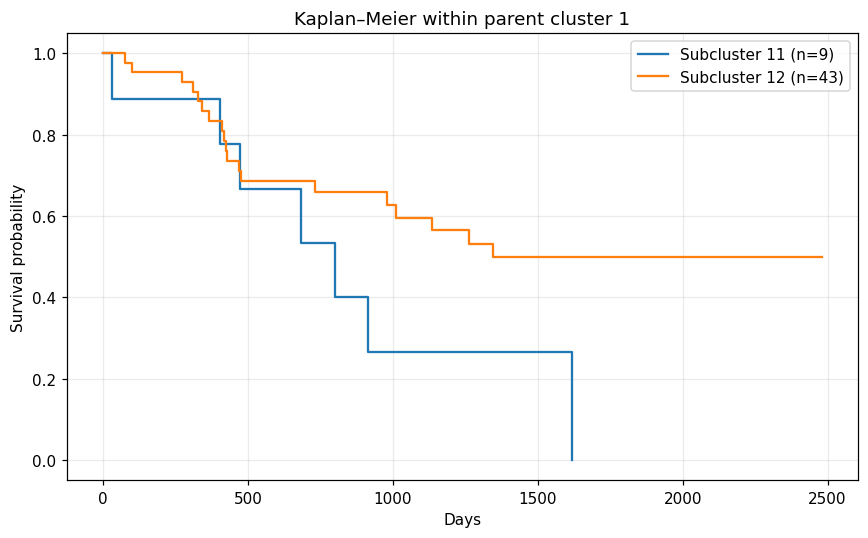

Global log-rank: chi2=2.795, dof=1, p=0.09458

Survival probabilities at fixed timepoints (NaN if insufficient follow-up):
   parent_cluster  subcluster_final  max_followup_days    S_365d   S_1095d  \
0               1                11             1619.0  0.888889  0.266667   
1               1                12             2481.0  0.834302  0.596010   

    S_1825d  
0       NaN  
1  0.498213  

------------------------------------------------------------------------------------------
Parent cluster 2: view_used_final=None | groups=[0] | groups_ok=[0]
Not enough subclusters with sufficient size for KM/log-rank within this parent cluster.


In [17]:
# Survival utilities (no external survival libraries)

def kaplan_meier_estimator(time: np.ndarray, event: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Step-wise KM survival curve (timeline, survival), no CI."""
    time = np.asarray(time, dtype=float)
    event = np.asarray(event, dtype=int)

    unique_event_times = np.unique(time[event == 1])
    unique_event_times.sort()

    surv = 1.0
    timeline = [0.0]
    survival = [1.0]

    for t in unique_event_times:
        at_risk = np.sum(time >= t)
        if at_risk == 0:
            continue
        d = np.sum((time == t) & (event == 1))
        surv *= (1.0 - d / at_risk)
        timeline.append(float(t))
        survival.append(float(surv))

    tmax = float(np.max(time))
    if timeline[-1] < tmax:
        timeline.append(tmax)
        survival.append(float(surv))

    return np.asarray(timeline), np.asarray(survival)

def km_survival_at(timeline: np.ndarray, survival: np.ndarray, t0: float) -> float:
    """Return S(t0) from a step KM curve (post-step)."""
    if t0 < 0:
        return float("nan")
    idx = np.searchsorted(timeline, t0, side="right") - 1
    idx = int(np.clip(idx, 0, len(survival) - 1))
    return float(survival[idx])

def logrank_test_multigroup(time: np.ndarray, event: np.ndarray, group: np.ndarray) -> tuple[float, float, int]:
    """Multi-group log-rank test with chi-square approximation."""
    time = np.asarray(time, dtype=float)
    event = np.asarray(event, dtype=int)
    group = np.asarray(group)

    groups = np.unique(group)
    k = len(groups)
    if k < 2:
        return float("nan"), float("nan"), 0

    group_to_idx = {g: i for i, g in enumerate(groups)}
    g_idx = np.array([group_to_idx[g] for g in group], dtype=int)

    event_times = np.unique(time[event == 1])
    event_times.sort()

    O = np.zeros(k, dtype=float)
    E = np.zeros(k, dtype=float)
    V = np.zeros((k, k), dtype=float)

    for t in event_times:
        at_risk = time >= t
        n = int(at_risk.sum())
        if n <= 1:
            continue
        d = int(np.sum((time == t) & (event == 1)))
        if d == 0:
            continue

        n_g = np.zeros(k, dtype=float)
        d_g = np.zeros(k, dtype=float)
        for i in range(k):
            mask = g_idx == i
            n_g[i] = float(np.sum(at_risk & mask))
            d_g[i] = float(np.sum((time == t) & (event == 1) & mask))

        O += d_g
        E += d * (n_g / n)

        factor = d * (n - d) / (n - 1)
        if factor <= 0:
            continue
        p = n_g / n
        V += factor * (np.diag(p) - np.outer(p, p))

    U = O - E
    dof = k - 1
    U_r = U[:-1]
    V_r = V[:-1, :-1]
    stat = float(U_r.T @ np.linalg.pinv(V_r) @ U_r)
    p_value = float(stats.chi2.sf(stat, dof))
    return stat, p_value, dof

survival_results = {}

timepoints = [365, 1095, 1825]

for parent in [1, 2]:
    df_p = df_sub[df_sub[PARENT_CLUSTER] == parent].copy()
    min_size = int(subclustering_results[parent]["min_cluster_size"])
    groups = sorted(df_p["subcluster_final"].unique().tolist())

    # Only consider groups with enough samples
    groups_ok = [g for g in groups if int((df_p["subcluster_final"] == g).sum()) >= min_size]

    print("\n" + "-" * 90)
    print(f"Parent cluster {parent}: view_used_final={view_used_final[parent]} | groups={groups} | groups_ok={groups_ok}")

    if len(groups_ok) < 2:
        print("Not enough subclusters with sufficient size for KM/log-rank within this parent cluster.")
        survival_results[parent] = {"status": "skipped_insufficient_groups"}
        continue

    # Event counts and rates
    rows = []
    for g in groups_ok:
        sub = df_p[df_p["subcluster_final"] == g]
        n = int(sub.shape[0])
        e = int(sub[TARGET_EVENT].sum())
        er = float(sub[TARGET_EVENT].mean())
        rows.append({"subcluster_final": int(g), "n": n, "events": e, "event_rate": er})
    event_table = pd.DataFrame(rows).sort_values("subcluster_final")
    print("\nEvent table:")
    print(event_table)

    total_events = int(df_p[TARGET_EVENT].sum())
    if total_events < 10:
        print("WARNING: Low number of events in this parent cluster -> low power for survival separation.")

    # KM plot
    plt.figure(figsize=(8, 5))
    km_curves = {}
    for g in groups_ok:
        sub = df_p[df_p["subcluster_final"] == g]
        t, s = kaplan_meier_estimator(sub[TARGET_TIME].to_numpy(), sub[TARGET_EVENT].to_numpy())
        km_curves[int(g)] = (t, s)
        plt.step(t, s, where="post", label=f"Subcluster {g} (n={sub.shape[0]})")

    plt.xlabel("Days")
    plt.ylabel("Survival probability")
    plt.title(f"Kaplan–Meier within parent cluster {parent}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Log-rank
    mask_ok = df_p["subcluster_final"].isin(groups_ok).to_numpy()
    time_ok = df_p.loc[mask_ok, TARGET_TIME].to_numpy()
    event_ok = df_p.loc[mask_ok, TARGET_EVENT].to_numpy()
    group_ok = df_p.loc[mask_ok, "subcluster_final"].to_numpy()

    lr_chi2, lr_p, lr_dof = logrank_test_multigroup(time_ok, event_ok, group_ok)
    print(f"Global log-rank: chi2={lr_chi2:.3f}, dof={lr_dof}, p={lr_p:.4g}")

    pairwise = None
    if len(groups_ok) > 2:
        pairs = list(itertools.combinations(groups_ok, 2))
        m = len(pairs)
        rows = []
        for a, b in pairs:
            mask = df_p["subcluster_final"].isin([a, b]).to_numpy()
            chi2_ab, p_ab, _ = logrank_test_multigroup(
                df_p.loc[mask, TARGET_TIME].to_numpy(),
                df_p.loc[mask, TARGET_EVENT].to_numpy(),
                df_p.loc[mask, "subcluster_final"].to_numpy(),
            )
            rows.append(
                {
                    "a": int(a),
                    "b": int(b),
                    "chi2": float(chi2_ab),
                    "p_value": float(p_ab),
                    "p_bonferroni": float(min(p_ab * m, 1.0)),
                }
            )
        pairwise = pd.DataFrame(rows).sort_values("p_value")
        print("\nPairwise log-rank (Bonferroni):")
        print(pairwise)

    # S(1y), S(3y), S(5y) if follow-up allows
    surv_tp_rows = []
    for g in groups_ok:
        sub = df_p[df_p["subcluster_final"] == g]
        max_fu = float(sub[TARGET_TIME].max())
        t, s = km_curves[int(g)]
        row = {"parent_cluster": parent, "subcluster_final": int(g), "max_followup_days": max_fu}
        for tp in timepoints:
            if max_fu >= tp:
                row[f"S_{tp}d"] = km_survival_at(t, s, tp)
            else:
                row[f"S_{tp}d"] = float("nan")
        surv_tp_rows.append(row)

    surv_tp = pd.DataFrame(surv_tp_rows)
    print("\nSurvival probabilities at fixed timepoints (NaN if insufficient follow-up):")
    print(surv_tp)

    survival_results[parent] = {
        "status": "ok",
        "groups_ok": groups_ok,
        "event_table": event_table,
        "logrank_global": {"chi2": float(lr_chi2), "p_value": float(lr_p), "dof": int(lr_dof)},
        "logrank_pairwise": pairwise,
        "survival_timepoints": surv_tp,
    }


## 8) Interpretation and final decision

We summarize, for each parent cluster:
- Whether View A has robust substructure
- Whether View B has robust substructure
- Whether there is survival separation
- Which variables define the subgroups

Conclusion rule-of-thumb:
- If View A is robust → report as **clinical subphenotypes**.
- If only View B is robust and top drivers are missingness/flags → report as **data availability profiles**.


In [18]:
def top_differential_variables(diff_df: pd.DataFrame, parent: int, top_n: int = 5) -> pd.DataFrame:
    if diff_df.empty:
        return pd.DataFrame()
    sub = diff_df[diff_df["parent_cluster"] == parent].sort_values("p_value")
    return sub.head(top_n)

summary_rows = []
for parent in [1, 2]:
    sel_A = subclustering_results[parent]["views"]["A"]["selected"]
    sel_B = subclustering_results[parent]["views"]["B"]["selected"]
    used = view_used_final[parent]

    top_vars = top_differential_variables(diff_df, parent=parent, top_n=8)
    top_vars_list = top_vars["variable"].tolist() if not top_vars.empty else []
    n_flags_in_top = sum(v in flag_cols for v in top_vars_list)
    flag_fraction = (n_flags_in_top / len(top_vars_list)) if top_vars_list else 0.0

    surv = survival_results.get(parent, {})
    lr_p = float(surv.get("logrank_global", {}).get("p_value", np.nan))

    interpretation = ""
    if used == "A":
        interpretation = "Clinical subphenotypes (View A selected)."
    elif used == "B":
        if flag_fraction >= 0.5:
            interpretation = "Likely data availability / missingness-driven (View B only; many top drivers are flags)."
        else:
            interpretation = "Operational profile (View B selected), but drivers are not dominated by flags."
    else:
        interpretation = "No robust substructure detected (subcluster_final=0)."

    summary_rows.append(
        {
            "parent_cluster": parent,
            "n_parent": subclustering_results[parent]["n_parent"],
            "view_A_selected": sel_A is not None,
            "view_A_K": int(sel_A["K"]) if sel_A else np.nan,
            "view_B_selected": sel_B is not None,
            "view_B_K": int(sel_B["K"]) if sel_B else np.nan,
            "view_used_final": used if used else "none",
            "logrank_p_within_parent": lr_p,
            "top_drivers": ", ".join(top_vars_list[:5]),
            "flag_fraction_in_top8": flag_fraction,
            "interpretation": interpretation,
        }
    )

summary_df = pd.DataFrame(summary_rows)
print("Final summary by parent cluster:")
print(summary_df)

# Collect results object
results = {
    "RANDOM_STATE": RANDOM_STATE,
    "input_path": str(INPUT_PATH),
    "output_dir": str(OUTPUT_DIR),
    "subclustering": subclustering_results,
    "view_used_final": view_used_final,
    "df_sub": df_sub,
    "perfil_subclusters": perfil_subclusters,
    "diff_subclusters": diff_df,
    "narratives": narr_df,
    "survival_results": survival_results,
    "summary": summary_df,
    "exports": {
        "df_con_subclusters_csv": str(OUTPUT_DIR / "df_con_subclusters.csv"),
        "perfil_subclusters_csv": str(OUTPUT_DIR / "perfil_subclusters.csv"),
    },
}

print("\nExports:")
for k, v in results["exports"].items():
    print(f"- {k}: {v}")


Final summary by parent cluster:
   parent_cluster  n_parent  view_A_selected  view_A_K  view_B_selected  \
0               1        52             True       2.0             True   
1               2        95            False       NaN            False   

   view_B_K view_used_final  logrank_p_within_parent  \
0       2.0               A                 0.094579   
1       NaN            none                      NaN   

                                         top_drivers  flag_fraction_in_top8  \
0  histo_defin, AP_ganPelv, afectacion_linf, asa,...                    0.0   
1                                                                       0.0   

                                      interpretation  
0          Clinical subphenotypes (View A selected).  
1  No robust substructure detected (subcluster_fi...  

Exports:
- df_con_subclusters_csv: cluster/df_con_subclusters.csv
- perfil_subclusters_csv: cluster/perfil_subclusters.csv


In [19]:
# 9) Export deterministic subcluster assigner for parent cluster 1
#
# This is meant for an individual calculator notebook:
# - First assign parent cluster (1/2)
# - If cluster==1, assign subcluster within cluster 1
#
# Critical constraints:
# - Do NOT use event/time_days as features
# - Use EXACT SAME preprocessing as model.ipynb by loading risk_model_rsf.joblib
#
from pathlib import Path
import json
import sys
import platform

import joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix

RANDOM_STATE = 42
ARTIFACT_DIR = Path('artifact')

PARENT_CLUSTER_COL = globals().get('PARENT_CLUSTER', 'cluster')
SUBCLUSTER_COL = 'subcluster_final'

# Load the fixed expected feature column order from model.ipynb artifacts
schema_path = ARTIFACT_DIR / 'feature_schema.json'
if not schema_path.exists():
    raise FileNotFoundError(
        'Missing feature_schema.json. Run model.ipynb export cells first to generate it.'
    )

with open(schema_path, 'r', encoding='utf-8') as f:
    feature_schema = json.load(f)

expected_columns = feature_schema.get('expected_columns')
if not expected_columns or not isinstance(expected_columns, list):
    raise ValueError('feature_schema.json must contain a non-empty expected_columns list.')

# Safety check: no leakage columns allowed
for _forbidden in ['event', 'time_days']:
    if _forbidden in expected_columns:
        raise ValueError(f'Forbidden leakage column found in expected_columns: {_forbidden}')

# Load the trained RSF pipeline and extract its (fitted) preprocessor
rsf_path = ARTIFACT_DIR / 'risk_model_rsf.joblib'
if not rsf_path.exists():
    raise FileNotFoundError(
        'Missing risk_model_rsf.joblib. Run model.ipynb export cells first to generate it.'
    )

risk_model_rsf = joblib.load(rsf_path)
if not hasattr(risk_model_rsf, 'named_steps') or 'preprocess' not in risk_model_rsf.named_steps:
    raise ValueError('risk_model_rsf.joblib must be a Pipeline with a preprocess step.')

shared_preprocess = risk_model_rsf.named_steps['preprocess']

# Choose the dataframe that contains subcluster_final
if 'df_sub' in globals():
    df_all = df_sub.copy()
elif 'df' in globals():
    df_all = df.copy()
else:
    raise ValueError('Expected `df_sub` or `df` in the notebook scope.')

for _col in [PARENT_CLUSTER_COL, SUBCLUSTER_COL]:
    if _col not in df_all.columns:
        raise ValueError(f'Missing required column in dataframe: {_col}')

# Filter to parent cluster 1 only
df1 = df_all[df_all[PARENT_CLUSTER_COL] == 1].copy()
if df1.empty:
    raise ValueError('No rows found for parent cluster 1.')

# y: original labels (e.g., 11/12). Drop 0 if it exists due to an upstream issue.
y_orig = df1[SUBCLUSTER_COL].astype(int)
mask_valid = y_orig != 0
if (~mask_valid).any():
    dropped = int((~mask_valid).sum())
    print(f'Warning: dropping {dropped} rows with {SUBCLUSTER_COL}=0 inside cluster 1.')
    df1 = df1.loc[mask_valid].copy()
    y_orig = df1[SUBCLUSTER_COL].astype(int)

orig_labels_sorted = sorted(pd.unique(y_orig).tolist())
if len(orig_labels_sorted) < 2:
    raise ValueError(f'Need >=2 subcluster labels inside cluster 1; got: {orig_labels_sorted}')

# Stable normalization: map original labels -> 0..K-1
label_map = {str(lbl): int(i) for i, lbl in enumerate(orig_labels_sorted)}
inv_label_map = {str(i): int(lbl) for i, lbl in enumerate(orig_labels_sorted)}

y = y_orig.map(lambda v: label_map[str(int(v))]).astype(int).to_numpy()

# X in fixed column order (calculator expects these exact input columns)
missing_cols = [c for c in expected_columns if c not in df1.columns]
if missing_cols:
    raise ValueError(f'Missing expected feature columns in df1: {missing_cols}')

X = df1[expected_columns].copy()

print('df1.shape:', df1.shape)
print('Subcluster original labels:', orig_labels_sorted)
print('Original label distribution (cluster 1):')
print(y_orig.value_counts().sort_index())


df1.shape: (52, 28)
Subcluster original labels: [11, 12]
Original label distribution (cluster 1):
subcluster_final
11     9
12    43
Name: count, dtype: int64


In [20]:
# Train and validate the subcluster-1 assigner
#
# Note: preprocessing is reused from the already-trained RSF pipeline (fitted on full data).
# The goal is deterministic assignment consistency, not maximizing performance.

# Pre-transform once with the fixed preprocessor
X_t = shared_preprocess.transform(X)
n_classes = len(orig_labels_sorted)

# 5-fold stratified CV (reduce folds only if the minority class is too small)
class_counts = pd.Series(y).value_counts().sort_index()
min_class = int(class_counts.min())
n_splits = 5
if min_class < n_splits:
    n_splits = min_class
    print(f'Warning: using n_splits={n_splits} because minority class count is {min_class}.')
if n_splits < 2:
    raise ValueError('Not enough samples per class to run stratified CV.')

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

bal_acc_folds = []
f1_folds = []
cm_sum = np.zeros((n_classes, n_classes), dtype=int)

for train_idx, test_idx in cv.split(X_t, y):
    clf = LogisticRegression(
        max_iter=5000,
        class_weight='balanced',
        solver='lbfgs',
        random_state=RANDOM_STATE,
    )
    clf.fit(X_t[train_idx], y[train_idx])
    y_pred = clf.predict(X_t[test_idx])

    bal_acc_folds.append(float(balanced_accuracy_score(y[test_idx], y_pred)))
    if n_classes == 2:
        f1_folds.append(float(f1_score(y[test_idx], y_pred, average='binary')))
    else:
        f1_folds.append(float(f1_score(y[test_idx], y_pred, average='macro')))

    cm_sum += confusion_matrix(y[test_idx], y_pred, labels=list(range(n_classes))).astype(int)

bal_acc_folds = np.asarray(bal_acc_folds, dtype=float)
f1_folds = np.asarray(f1_folds, dtype=float)

bal_acc_mean = float(bal_acc_folds.mean())
bal_acc_std = float(bal_acc_folds.std(ddof=1)) if bal_acc_folds.size > 1 else 0.0
f1_mean = float(f1_folds.mean())
f1_std = float(f1_folds.std(ddof=1)) if f1_folds.size > 1 else 0.0

print(f'CV (n_splits={n_splits}) balanced_accuracy: {bal_acc_mean:.3f} ± {bal_acc_std:.3f}')
print(f'CV (n_splits={n_splits}) f1: {f1_mean:.3f} ± {f1_std:.3f}')

cm_df = pd.DataFrame(
    cm_sum,
    index=[f'true_{i}' for i in range(n_classes)],
    columns=[f'pred_{i}' for i in range(n_classes)],
)
print('\nAggregated CV confusion matrix (sum over folds):')
print(cm_df)

# Fit final classifier on ALL cluster-1 data (deterministic assigner)
clf_final = LogisticRegression(
    max_iter=5000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=RANDOM_STATE,
)
clf_final.fit(X_t, y)

subcluster1_assigner = Pipeline(steps=[('preprocess', shared_preprocess), ('clf', clf_final)])

y_pred_train = subcluster1_assigner.predict(X)
cm_train = confusion_matrix(y, y_pred_train, labels=list(range(n_classes))).astype(int)

print('\nTrain distribution (mapped labels):')
print(pd.Series(y).value_counts().sort_index())
print('Predicted distribution on train (mapped labels):')
print(pd.Series(y_pred_train).value_counts().sort_index())

# Export artifacts
joblib.dump(subcluster1_assigner, ARTIFACT_DIR / 'subcluster1_assigner.joblib')
print('Exported:', ARTIFACT_DIR / 'subcluster1_assigner.joblib')

label_map_payload = {
    'original_to_model': label_map,
    'model_to_original': inv_label_map,
    'original_labels_sorted': orig_labels_sorted,
}
with open(ARTIFACT_DIR / 'subcluster1_label_map.json', 'w', encoding='utf-8') as f:
    json.dump(label_map_payload, f, indent=2, ensure_ascii=False)
print('Exported:', ARTIFACT_DIR / 'subcluster1_label_map.json')

# Summary JSON for auditing
import sklearn

orig_counts = y_orig.value_counts().sort_index()
mapped_counts = pd.Series(y).value_counts().sort_index()

summary = {
    'parent_cluster': 1,
    'n_samples': int(df1.shape[0]),
    'subcluster_original_counts': {str(k): int(v) for k, v in orig_counts.items()},
    'subcluster_mapped_counts': {str(k): int(v) for k, v in mapped_counts.items()},
    'label_map': label_map_payload,
    'cv': {
        'n_splits': int(n_splits),
        'balanced_accuracy_mean': bal_acc_mean,
        'balanced_accuracy_std': bal_acc_std,
        'f1_mean': f1_mean,
        'f1_std': f1_std,
        'confusion_matrix_sum': cm_sum.tolist(),
    },
    'train_confusion_matrix': cm_train.tolist(),
    'model': {
        'type': 'LogisticRegression',
        'params': {k: (v.item() if hasattr(v, 'item') else v) for k, v in clf_final.get_params().items()},
    },
    'versions': {
        'python': sys.version,
        'platform': platform.platform(),
        'numpy': np.__version__,
        'pandas': pd.__version__,
        'sklearn': sklearn.__version__,
        'joblib': joblib.__version__,
    },
}

with open(ARTIFACT_DIR / 'subcluster1_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)
print('Exported:', ARTIFACT_DIR / 'subcluster1_summary.json')


CV (n_splits=5) balanced_accuracy: 0.939 ± 0.108
CV (n_splits=5) f1: 0.978 ± 0.031

Aggregated CV confusion matrix (sum over folds):
        pred_0  pred_1
true_0       8       1
true_1       1      42

Train distribution (mapped labels):
0     9
1    43
Name: count, dtype: int64
Predicted distribution on train (mapped labels):
0     9
1    43
Name: count, dtype: int64
Exported: artifact/subcluster1_assigner.joblib
Exported: artifact/subcluster1_label_map.json
Exported: artifact/subcluster1_summary.json


In [21]:
# Smoke test: 3 real cluster-1 patients

assigner_loaded = joblib.load(ARTIFACT_DIR / 'subcluster1_assigner.joblib')
with open(ARTIFACT_DIR / 'subcluster1_label_map.json', 'r', encoding='utf-8') as f:
    maps_loaded = json.load(f)
inv_map_loaded = maps_loaded['model_to_original']

df_smoke = df1.sample(n=min(3, df1.shape[0]), random_state=RANDOM_STATE).copy()
X_smoke = df_smoke[expected_columns].copy()

y_pred_mapped = assigner_loaded.predict(X_smoke)
y_pred_orig = [int(inv_map_loaded[str(int(v))]) for v in y_pred_mapped]

proba = None
if hasattr(assigner_loaded, 'predict_proba'):
    proba = assigner_loaded.predict_proba(X_smoke)

print('\n--- Smoke test (cluster 1) ---')
for i, (idx, row) in enumerate(df_smoke.iterrows()):
    true_orig = int(row[SUBCLUSTER_COL])
    pred_orig = y_pred_orig[i]
    print(f'\nPatient index: {idx}')
    print(f'  true_subcluster_final: {true_orig} | pred_subcluster_final: {pred_orig}')

    if proba is not None:
        # Map probabilities to original labels for readability
        proba_row = proba[i]
        proba_by_orig = {int(inv_map_loaded[str(j)]): float(proba_row[j]) for j in range(proba_row.shape[0])}
        print('  predicted_proba_by_original_label:', proba_by_orig)



--- Smoke test (cluster 1) ---

Patient index: 67
  true_subcluster_final: 12 | pred_subcluster_final: 12
  predicted_proba_by_original_label: {11: 0.04117042710034169, 12: 0.9588295728996583}

Patient index: 104
  true_subcluster_final: 12 | pred_subcluster_final: 12
  predicted_proba_by_original_label: {11: 0.0009630597482918057, 12: 0.9990369402517082}

Patient index: 116
  true_subcluster_final: 11 | pred_subcluster_final: 11
  predicted_proba_by_original_label: {11: 0.9256382199009423, 12: 0.0743617800990577}
